In [62]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  

import numpy as np
import xarray as xr
import pandas as pd

import scipy as sp
import scipy.sparse
import scipy.linalg
from scipy.sparse.linalg import cg
from scipy.optimize import curve_fit

In [307]:
#fitting function:
def fit_timesat(x,a,b,c,d,e,f):
    return a+b*(1/(1+np.exp((c-x)/d))-1/(1+np.exp((e-x)/f)))

In [308]:
def whitsm(y, lmda):
    m = len(y)
    E = sp.sparse.identity(m)
    
    d1 = -1 * np.ones((m),dtype='d')
    d2 = 3 * np.ones((m),dtype='d')
    d3 = -3 * np.ones((m),dtype='d')
    d4 = np.ones((m),dtype='d')
    D = sp.sparse.diags([d1,d2,d3,d4],[0,1,2,3], shape=(m-3, m), format="csr")
    #print(D)
    z = sp.sparse.linalg.cg(E + lmda * (D.transpose()).dot(D), y)

    return z[0]

In [309]:
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import splu


def speyediff(N, d, format='csc'):
    """
    (utility function)
    Construct a d-th order sparse difference matrix based on 
    an initial N x N identity matrix
    
    Final matrix (N-d) x N
    """
    
    assert not (d < 0), "d must be non negative"
    shape     = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format=format)
    return spmat


def whittaker_smooth(y, lmbd, d = 2):
    """
    Implementation of the Whittaker smoothing algorithm,
    based on the work by Eilers [1].
    [1] P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, (75), 3631-3636
    
    The larger 'lmbd', the smoother the data.
    For smoothing of a complete data series, sampled at equal intervals
    This implementation uses sparse matrices enabling high-speed processing
    of large input vectors
    
    ---------
    
    Arguments :
    
    y       : vector containing raw data
    lmbd    : parameter for the smoothing algorithm (roughness penalty)
    d       : order of the smoothing 
    
    ---------
    Returns :
    
    z       : vector of the smoothed data.
    """

    m = len(y)
    E = sparse.eye(m, format='csc')
    D = speyediff(m, d, format='csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return z  

Lets load a small NDVI dataset.
This is combined MODIS Terra & Aqua for a little 5x6 grid at the Llupa AWS+EC site!

In [310]:
data = terra = xr.open_dataset('Llupa_AquaTerra.nc')
data

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 6, time: 875)
Coordinates:
  * lon      (lon) float64 -77.48 -77.48 -77.48 -77.48 -77.48 -77.47
  * lat      (lat) float64 -9.507 -9.509 -9.511 -9.514 -9.516
  * time     (time) datetime64[ns] 2000-02-18 2000-03-05 ... 2020-04-22
Data variables:
    NDVI_QA  (time, lat, lon) float32 ...

In [311]:
#convert our 3D data into 2D (by multiindexing lat/lon)
stack = data.stack(allpoints = ['lat', 'lon']).squeeze()
ndvi = stack['NDVI_QA']

Lets just use one pixel and one year as an example. Basically, this is exactly what will happen in the end for each pixel and year in a loop!

My idea here is, to get the inflexion points of the fitted curve as possible metrics for Start an End of the Season. The Inflexion points correspond to the Intersection with y=0 of the second derivative.

Later I also want to try some other metrics, e.g.
- Cardinal points
- Absolute thresholds (e.g. time when NDVI > 0.4)
- Relative thresholds (e.g. time when NDVI reaches 25% of amplitude

but this works only once I solved my current problem.


In case, anyone knows a better solution to this than what I came up with, just let me know!

In [312]:
#Select one vegetation period for one pixel as an example here
rydat = ndvi.loc['08-01-2005':'07-31-2006'][:,15].values
rxdat = np.arange(0,len(rydat))
xdatfit = np.linspace(np.min(rxdat),np.max(rxdat), 365)

#remove NaNs from x and y

idx = np.isnan(rxdat) | np.isnan(rydat)
xdat = rxdat[~idx]
ydat = rydat[~idx]

#apply smoother, the 1000 is just a parameter for the smoothing
#try changing it (e.g. 1,10,1000,10000) if you are interested
wt = whittaker_smooth(ydat,1000, d=5)

#starting values
p0 = np.array([np.percentile(wt,q=5), np.percentile(wt,q=95)- np.percentile(wt,q=5), 5, 1, 20, 1])
#fitting algorithm
popt, pcov = curve_fit(fit_timesat,xdat, wt, p0,maxfev=10000)

perr = np.sqrt(np.diag(pcov)) 
#so there I could potentially put a custom x but (see below)
fit = fit_timesat(xdatfit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])

#get 2. derivate
sec_deriv = np.gradient(np.gradient(fit)) 

#get interception with 0 of 2. derivate which correspond to inflexion points of the fitted curve
infls = np.where(np.diff(np.sign(sec_deriv)))[0]

In [313]:
from scipy import interpolate
f = interpolate.interp1d(xdat, wt)

In [314]:
ydatfit = f(xdatfit)

In [315]:
wt2 = whittaker_smooth(ydatfit,80, d=1)

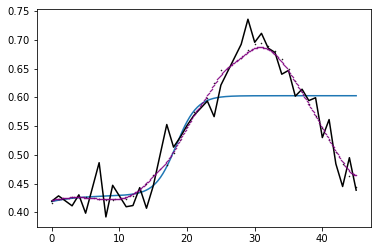

In [317]:
plt.plot(xdatfit, fit)
plt.plot(xdat, ydat, 'k')
plt.plot(xdat, wt, linestyle='', color='k', markersize=0.5, marker='o')
plt.plot(xdatfit, wt2, linestyle='', color='purple', markersize=0.5, marker='o')

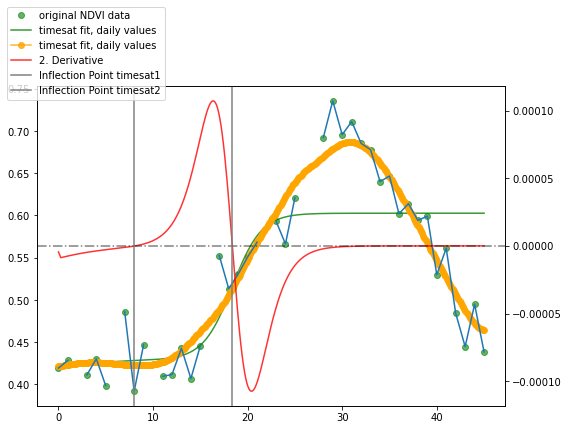

In [301]:
fig, ax = plt.subplots(figsize=(8,5))
#Plot raw NDVI data
#plot_x_time = ndvi.loc['08-01-2005':'07-31-2006'].time[~idx] #this is ugly, quick workaround for time on xaxis
ax.plot(xdat,ydat,'go',alpha=0.6,label='original NDVI data')

#Plot fitted data
ax.plot(xdatfit,fit,'green',alpha=0.8,label='timesat fit, daily values')
ax.plot(xdatfit,wt2,'orange',alpha=0.8,label='timesat fit, daily values', marker='o') #1d interpol smoothed

plt.plot(rxdat,rydat)

#Plot 2. derivative and the inflexion points
ax2 = ax.twinx()
ax2.plot(xdatfit,sec_deriv,'red',alpha=0.8,label='2. Derivative')
ax2.axhline(c='k',linestyle='-.',alpha=0.5,y=0)

#Plot vertical lines
for i, infl in enumerate(infls, 1):
    ax2.axvline(x=xdatfit[infl], color='grey', label=f'Inflection Point timesat{i}')

plt.tight_layout()
fig.legend(bbox_to_anchor=(0.3,1.2))

Ok, so again this works ok (more or less...) but the problem is the same. But now I have the parameters

This does not work because the fitting parameters are tuned to another x_range?

maybe I have to adjust them from x=23 to x=365 by multiplying popt[2] and popt[4] which correspond to the x position of the sigmoids?

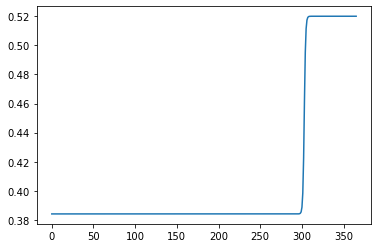

In [23]:
fit_daily = fit_timesat(np.arange(0,366,1),popt[0],popt[1],popt[2]*(365/23),popt[3],popt[4]*(365/23),popt[5])
plt.plot(np.arange(len(fit_daily)),fit_daily)

nah... ideas?